<a href="https://colab.research.google.com/github/cole-beach/Loan-Risk/blob/main/Loan_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Risk

## Problem:


A bank in India would like to get a better understanding of customers who apply for loans.  

*They would like you to:*
 
 1. Segment the customers into groups of similar customers and report on those groups, and 
 
 2. Create a model that can classify customers into high and low risk groups.  They have provided a database of current customers labeled with whether they are a high or low risk loan candidate.

### Data notes:

**Income** = Indian Rupees

# Part I

## Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
sns.set_style("whitegrid")

#Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo: Data Science/03 Data Science: Advanced Machine Learning/Belt Exam Re-Take/Data/loan_cluster_df.csv')
pd.set_option('display.max_columns', None)
display(df.head())

,Income,Age,Experience,Married,Owns_House,Owns_Car,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,3635824,56,8,0,0,0,8,13,1
1,3231341,47,6,1,0,0,6,14,0
2,7430695,59,8,0,0,0,8,10,0
3,8688710,47,1,0,0,0,1,10,0
4,2229190,21,11,0,0,0,9,11,0


## Exploring & Cleaning the Dataset

In [ ]:
print(df.info(),'\n')
print(f'The shape of the Dataset is: {df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19438 entries, 0 to 19437
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Income             19438 non-null  int64
 1   Age                19438 non-null  int64
 2   Experience         19438 non-null  int64
 3   Married            19438 non-null  int64
 4   Owns_House         19438 non-null  int64
 5   Owns_Car           19438 non-null  int64
 6   CURRENT_JOB_YRS    19438 non-null  int64
 7   CURRENT_HOUSE_YRS  19438 non-null  int64
 8   Risk_Flag          19438 non-null  int64
dtypes: int64(9)
memory usage: 1.3 MB
None 

The shape of the Dataset is: (19438, 9)


In [ ]:
print(f'There are {df.duplicated().sum()} duplicated values','\n')
print(f'===========================================\n\n Missing Values:')
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

There are 10463 duplicated values 


 Missing Values:


,Total,Percent
Income,0,0.0
Age,0,0.0
Experience,0,0.0
Married,0,0.0
Owns_House,0,0.0


In [ ]:
df.drop_duplicates(inplace=True)
print(f'After dropping duplicated values we have {df.duplicated().sum()} shown in the dataset')

After dropping duplicated values we have 0 shown in the dataset


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,8975.0,5.014217e+06,2.883422e+06,10310.0,2521816.0,5003243.0,7497723.0,9999180.0
Age,8975.0,5.001582e+01,1.697370e+01,21.0,35.0,50.0,65.0,79.0
Experience,8975.0,1.003721e+01,6.002911e+00,0.0,5.0,10.0,15.0,20.0
Married,8975.0,1.021727e-01,3.028922e-01,0.0,0.0,0.0,0.0,1.0
Owns_House,8975.0,5.381616e-02,2.256671e-01,0.0,0.0,0.0,0.0,1.0
Owns_Car,8975.0,3.016156e-01,4.589849e-01,0.0,0.0,0.0,1.0,1.0
CURRENT_JOB_YRS,8975.0,6.328022e+00,3.639975e+00,0.0,3.0,6.0,9.0,14.0
CURRENT_HOUSE_YRS,8975.0,1.200457e+01,1.406265e+00,10.0,11.0,12.0,13.0,14.0
Risk_Flag,8975.0,1.664624e-01,3.725159e-01,0.0,0.0,0.0,0.0,1.0


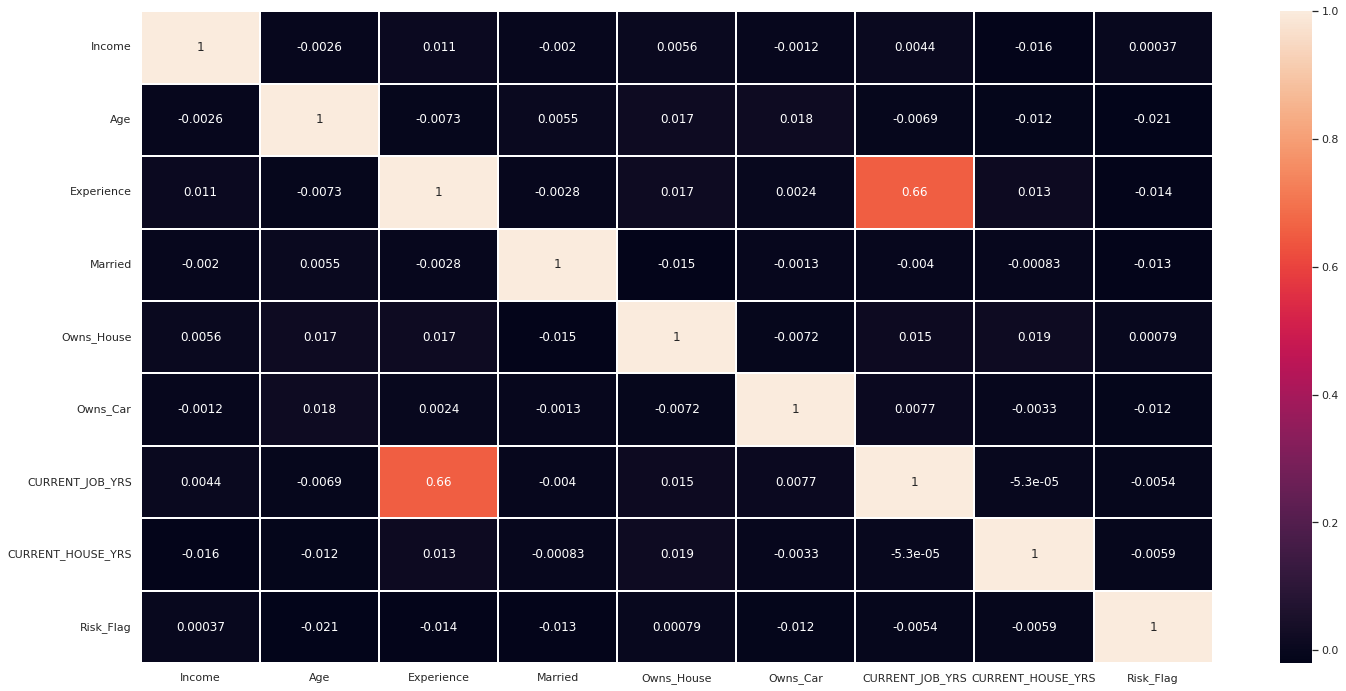

In [ ]:
plt.figure(figsize = (24, 12))

corr = df.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

## Preprocessing

In [ ]:
# Scale
scaler = StandardScaler()

# Fit & Transfor the Dataset
scaled_df = scaler.fit_transform(df)

## KMeans Model

CPU times: user 17.8 s, sys: 4.17 s, total: 21.9 s
Wall time: 15 s


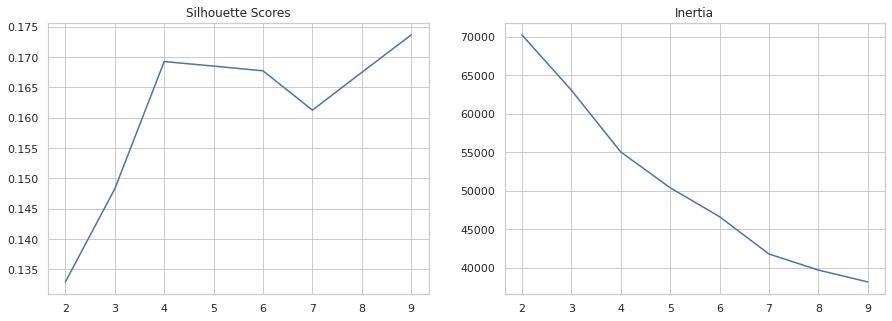

In [ ]:
%%time

# Locating the optimal number of clusters
k_range = range(2,10) # I'm using 11 to visualize the number 10 on the plot.
sils = []
inertias = []

# For Loop through the set range. 
for k in k_range:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(scaled_df)
  sils.append(silhouette_score(scaled_df, kmeans.labels_))
  inertias.append(kmeans.inertia_)

#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(k_range, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(k_range)
axes[1].plot(k_range, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(k_range);

Our Silhouette Score peaks at 6 clusters and there's a clear Inertia elbow at 6 clusters, which makes it safe to say the number of clusters we should use is 6. 

### Fitting a new model with the number of clusters.

In [ ]:
kmeans_6 = KMeans(n_clusters=6, random_state=42)
kmeans_6.fit(scaled_df)

# Adding the clusters as a column to the dataframe
df['clusters'] = kmeans_6.labels_

# Analyzing the Clusters
cluster_groups = df.groupby('clusters', as_index=False).mean()
cluster_groups

,clusters,Income,Age,Experience,Married,Owns_House,Owns_Car,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,0,4.988545e+06,49.593313,14.528830,0.000000,0.0,0.000000,8.596383,12.034118,0.167178
1,1,5.086717e+06,50.031906,4.502519,0.000000,0.0,0.000000,3.485726,11.953401,0.173804
2,2,5.196943e+06,49.514610,14.461851,0.000000,0.0,1.000000,8.797078,11.913149,0.163149
3,3,5.082334e+06,51.231884,10.455487,0.082816,1.0,0.287785,6.559006,12.113872,0.167702
4,4,4.729983e+06,50.957009,4.787850,0.000000,0.0,1.000000,3.533645,12.094393,0.162617
5,5,4.955678e+06,50.270239,10.017104,1.000000,0.0,0.303307,6.280502,12.003421,0.152794


### Visualization

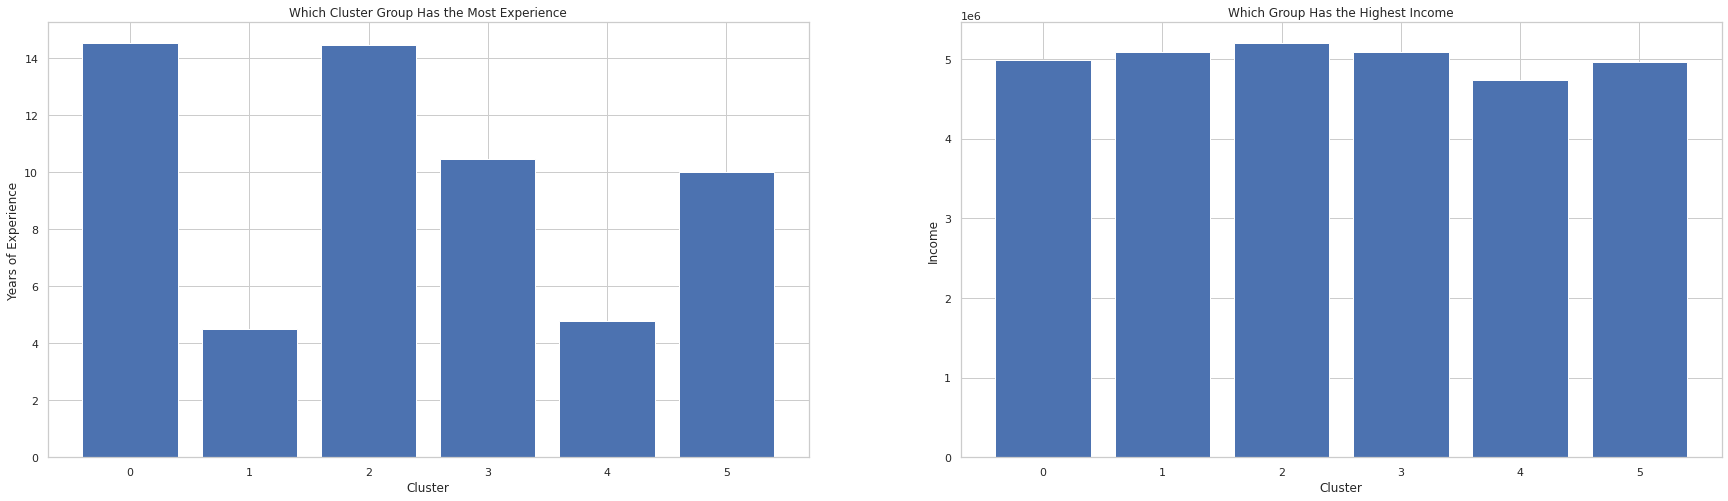

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(30,8))

# Most Experience
axes[0].bar(cluster_groups.index, cluster_groups['Experience'])
axes[0].set_title('Which Cluster Group Has the Most Experience')
axes[0].set_ylabel('Years of Experience')
axes[0].set_xlabel('Cluster')
axes[0].set_xticks(cluster_groups.index)

# Income Cluster Group
axes[1].bar(cluster_groups.index, cluster_groups['Income'])
axes[1].set_title('Which Group Has the Highest Income')
axes[1].set_ylabel('Income')
axes[1].set_xlabel('Cluster')
axes[1].set_xticks(cluster_groups.index);

### Differences Between the Cluster Groups

Cluster-0 and Cluster-2 both have the most experience with just over 14-years. However, it's clear that the individuals in Cluster-0, although having that much experience, are not being compensated for the amount. It is very clear that those in Cluster-2 are receiving the highest income which can show that their amount of experince could play a roll  in their compensation. 

Cluster-0 also receives less pay than Cluster-1 who only has a little over 4-years of experience and Cluster-3 who only have just over 10-years of experience. It even looks like Cluster-1 and Cluster-3 get paid the same amount. 

From this information we can always dive further into other factors that can be playing into some Cluster groups making more with less experince. We can check to see if those groups have a higher number of married couples, rather than those that are on a single income. We can always look at the number of years that these gourps have been at their jobs. 

# Part II

## Loading the Model Dataset

In [ ]:
model_df = pd.read_csv('/content/drive/MyDrive/Coding Dojo: Data Science/03 Data Science: Advanced Machine Learning/Belt Exam Re-Take/Data/loan_model_df.csv')
pd.set_option('display.max_columns', None)
model_df.head()

,Income,Age,Experience,Married,Owns_House,Owns_Car,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Profession_Air_traffic_controller,Profession_Analyst,Profession_Architect,Profession_Army_officer,Profession_Artist,Profession_Aviator,Profession_Biomedical_Engineer,Profession_Chartered_Accountant,Profession_Chef,Profession_Chemical_engineer,Profession_Civil_engineer,Profession_Civil_servant,Profession_Comedian,Profession_Computer_hardware_engineer,Profession_Computer_operator,Profession_Consultant,Profession_Dentist,Profession_Design_Engineer,Profession_Designer,Profession_Drafter,Profession_Economist,Profession_Engineer,Profession_Fashion_Designer,Profession_Financial_Analyst,Profession_Firefighter,Profession_Flight_attendant,Profession_Geologist,Profession_Graphic_Designer,Profession_Hotel_Manager,Profession_Industrial_Engineer,Profession_Lawyer,Profession_Librarian,Profession_Magistrate,Profession_Mechanical_engineer,Profession_Microbiologist,Profession_Official,Profession_Petroleum_Engineer,Profession_Physician,Profession_Police_officer,Profession_Politician,Profession_Psychologist,Profession_Scientist,Profession_Secretary,Profession_Software_Developer,Profession_Statistician,Profession_Surgeon,Profession_Surveyor,Profession_Technical_writer,Profession_Technician,Profession_Technology_specialist,Profession_Web_designer,CITY_Adoni,CITY_Agartala,CITY_Agra,CITY_Ahmedabad,CITY_Ahmednagar,CITY_Aizawl,CITY_Ajmer,CITY_Akola,CITY_Alappuzha,CITY_Aligarh,CITY_Allahabad,CITY_Alwar,CITY_Amaravati,CITY_Ambala,CITY_Ambarnath,CITY_Ambattur,CITY_Amravati,CITY_Amritsar,CITY_Amroha,CITY_Anand,CITY_Anantapur,CITY_Anantapuram[24],CITY_Arrah,CITY_Asansol,CITY_Aurangabad,CITY_Aurangabad[39],CITY_Avadi,CITY_Bahraich,CITY_Ballia,CITY_Bally,CITY_Bangalore,CITY_Baranagar,CITY_Barasat,CITY_Bardhaman,CITY_Bareilly,CITY_Bathinda,CITY_Begusarai,CITY_Belgaum,CITY_Bellary,CITY_Berhampore,CITY_Berhampur,CITY_Bettiah[33],CITY_Bhagalpur,CITY_Bhalswa_Jahangir_Pur,CITY_Bharatpur,CITY_Bhatpara,CITY_Bhavnagar,CITY_Bhilai,CITY_Bhilwara,CITY_Bhimavaram,CITY_Bhind,CITY_Bhiwandi,CITY_Bhiwani,CITY_Bhopal,CITY_Bhubaneswar,CITY_Bhusawal,CITY_Bidar,CITY_Bidhannagar,CITY_Bihar_Sharif,CITY_Bijapur,CITY_Bikaner,CITY_Bilaspur,CITY_Bokaro,CITY_Bongaigaon,CITY_Bulandshahr,CITY_Burhanpur,CITY_Buxar[37],CITY_Chandigarh_city,CITY_Chandrapur,CITY_Chapra,CITY_Chennai,CITY_Chinsurah,CITY_Chittoor[28],CITY_Coimbatore,CITY_Cuttack,CITY_Danapur,CITY_Darbhanga,CITY_Davanagere,CITY_Dehradun,CITY_Dehri[30],CITY_Delhi_city,CITY_Deoghar,CITY_Dewas,CITY_Dhanbad,CITY_Dharmavaram,CITY_Dhule,CITY_Dibrugarh,CITY_Dindigul,CITY_Durg,CITY_Durgapur,CITY_Eluru[25],CITY_Erode[17],CITY_Etawah,CITY_Faridabad,CITY_Farrukhabad,CITY_Fatehpur,CITY_Firozabad,CITY_Gandhidham,CITY_Gandhinagar,CITY_Gangtok,CITY_Gaya,CITY_Ghaziabad,CITY_Giridih,CITY_Gopalpur,CITY_Gorakhpur,CITY_Gudivada,CITY_Gulbarga,CITY_Guna,CITY_Guntakal,CITY_Guntur[13],CITY_Gurgaon,CITY_Guwahati,CITY_Gwalior,CITY_Hajipur[31],CITY_Haldia,CITY_Hapur,CITY_Haridwar,CITY_Hazaribagh,CITY_Hindupur,CITY_Hospet,CITY_Hosur,CITY_Howrah,CITY_HubliÃ¢â‚¬â€œDharwad,CITY_Hyderabad,CITY_Ichalkaranji,CITY_Imphal,CITY_Indore,CITY_Jabalpur,CITY_Jaipur,CITY_Jalandhar,CITY_Jalgaon,CITY_Jalna,CITY_Jamalpur[36],CITY_Jammu[16],CITY_Jamnagar,CITY_Jamshedpur,CITY_Jaunpur,CITY_Jehanabad[38],CITY_Jhansi,CITY_Jodhpur,CITY_Jorhat,CITY_Junagadh,CITY_Kadapa[23],CITY_Kakinada,CITY_Kalyan-Dombivli,CITY_Kamarhati,CITY_Kanpur,CITY_Karaikudi,CITY_Karawal_Nagar,CITY_Karimnagar,CITY_Karnal,CITY_Katihar,CITY_Katni,CITY_Kavali,CITY_Khammam,CITY_Khandwa,CITY_Kharagpur,"CITY_Khora,_Ghaziabad",CITY_Kirari_Suleman_Nagar,CITY_Kishanganj[35],CITY_Kochi,CITY_Kolhapur,CITY_Kolkata,CITY_Kollam,CITY_Korba,CITY_Kota[6],CITY_Kottayam,CITY_Kozhikode,CITY_Kulti,CITY_Kumbakonam,CITY_Kurnool[18],CITY_Latur,CITY_Loni,CITY_Lucknow,CITY_Ludhiana,CITY_Machilipatnam,CITY_Madanapalle,CITY_Madhyamgram,CITY_Madurai,CITY_Mahbubnagar,CITY_Maheshtala,CITY_Malda,CITY_Malegaon,CITY_Mangalore,CITY_Mango,CITY_Mathur

## Exploring & Cleaning the Model Dataset

In [ ]:
display(model_df.describe().T)
print(f'\n=============================================================================================================\n')
display(model_df.info(verbose=True))
print(f'\n=============================================================================================================\n')
print(f'The Shape of the Dataset is {model_df.shape}')

,count,mean,std,min,25%,50%,75%,max
Income,19438.0,5.043779e+06,2.885391e+06,10310.0,2533055.0,5046887.5,7532549.0,9999180.0
Age,19438.0,4.981264e+01,1.696799e+01,21.0,35.0,50.0,64.0,79.0
Experience,19438.0,1.013793e+01,5.985557e+00,0.0,5.0,10.0,15.0,20.0
Married,19438.0,1.051034e-01,3.066945e-01,0.0,0.0,0.0,0.0,1.0
Owns_House,19438.0,5.262887e-02,2.232972e-01,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
STATE_Tripura,19438.0,4.115650e-03,6.402282e-02,0.0,0.0,0.0,0.0,1.0
STATE_Uttar_Pradesh,19438.0,1.113283e-01,3.145464e-01,0.0,0.0,0.0,0.0,1.0
STATE_Uttar_Pradesh[5],19438.0,2.880955e-03,5.359853e-02,0.0,0.0,0.0,0.0,1.0
STATE_Uttarakhand,19438.0,6.893713e-03,8.274384e-02,0.0,0.0,0.0,0.0,1.0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19438 entries, 0 to 19437
Data columns (total 406 columns):
 #    Column                                 Dtype
---   ------                                 -----
 0    Income                                 int64
 1    Age                                    int64
 2    Experience                             int64
 3    Married                                int64
 4    Owns_House                             int64
 5    Owns_Car                               int64
 6    CURRENT_JOB_YRS                        int64
 7    CURRENT_HOUSE_YRS                      int64
 8    Risk_Flag                              int64
 9    Profession_Air_traffic_controller      int64
 10   Profession_Analyst                     int64
 11   Profession_Architect                   int64
 12   Profession_Army_officer                int64
 13   Profession_Artist                      int64
 14   Profession_Aviator                     int64
 15   Profession_Biom

None



The Shape of the Dataset is (19438, 406)


In [ ]:
print(f'There are {model_df.duplicated().sum()} duplicated values','\n')
print(f'===========================================\n\n Missing Values:')
total = model_df.isnull().sum().sort_values(ascending=False)
percent = (model_df.isnull().sum()/model_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

There are 10463 duplicated values 


 Missing Values:


,Total,Percent
Income,0,0.0
CITY_Nanded,0,0.0
CITY_North_Dumdum,0,0.0
CITY_Noida,0,0.0
CITY_Nizamabad,0,0.0


In [ ]:
model_df.drop_duplicates(inplace=True)
print(f'After dropping duplicated values we have {model_df.duplicated().sum()} shown in the dataset')

After dropping duplicated values we have 0 shown in the dataset


## Preprocessing

In [ ]:
X = model_df.drop(columns='Risk_Flag')
y = model_df['Risk_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [ ]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Instantiate PCA to explain 95% of variance
pca = PCA(n_components=.95)

pipeline_proc = make_pipeline(scaler, pca)

# fit on train
X_train_proc = pipeline_proc.fit_transform(X_train)
X_test_proc = pipeline_proc.transform(X_test)

print('Shape before PCA:', X_train.shape)
print('Shape after PCA:', pipeline_proc.fit_transform(X_train).shape)
print('Column count reduced by: ', X_train.shape[1] - pipeline_proc.fit_transform(X_train_proc).shape[1])

Shape before PCA: (6731, 405)
Shape after PCA: (6731, 347)
Column count reduced by:  75


### Plotting Function

In [ ]:
#  You can use this function to see how your model improves over time
def plot_history(history, metric=None):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (25, 8))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    axes[1].legend()

  plt.show()

# Binary Classification Models

## Model 1

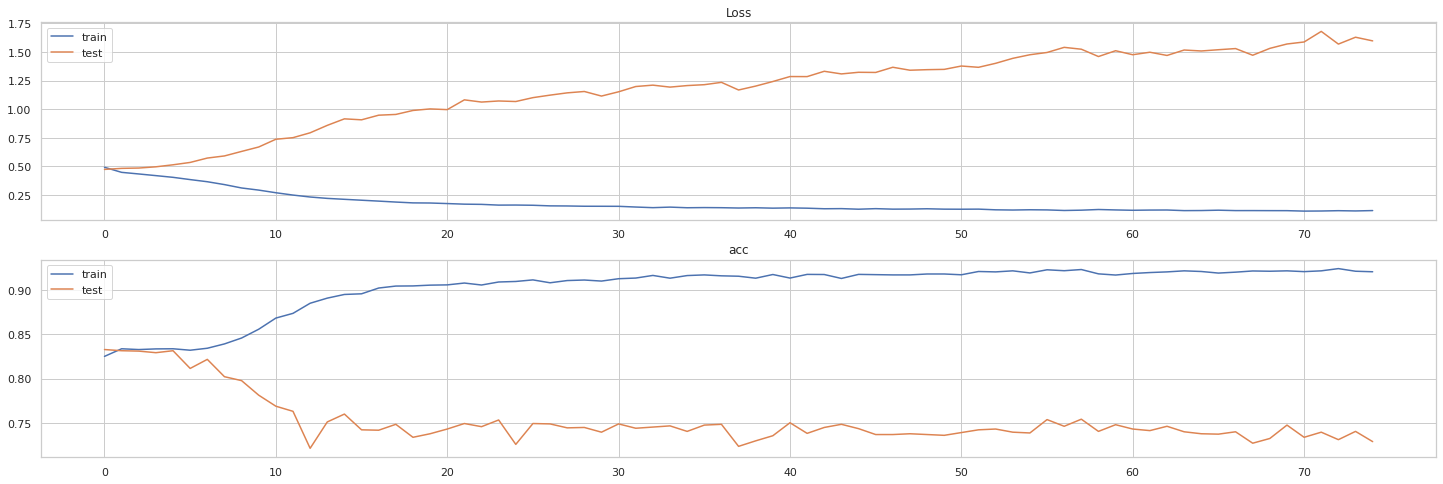

In [ ]:
# Instentiate the model
class_model = Sequential()

# Input layer. I'm using the number of features after PCA has been applied as a rule of thumb.
class_model.add(Dense(300, activation = 'relu', input_dim = X_train_proc.shape[1]))

# Create hidden layers
class_model.add(Dense(50, activation = 'relu'))

# Create output layer 
# Since this is a binary classification, the activation function of our final layer needs to be 'sigmoid'. 

class_model.add(Dense(1, activation = 'sigmoid'))

# compile model with metrics
class_model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

history = class_model.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 75, verbose=0)

# plot learning history
plot_history(history, 'acc')

### Model 1 - Score (73%)


Training Scores
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5611
           1       0.79      0.90      0.84      1120

    accuracy                           0.94      6731
   macro avg       0.88      0.92      0.90      6731
weighted avg       0.95      0.94      0.94      6731



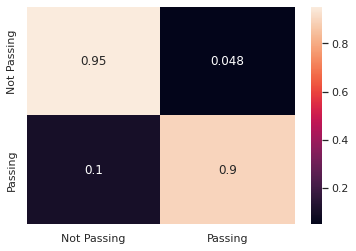



Testing Scores
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1870
           1       0.07      0.05      0.06       374

    accuracy                           0.73      2244
   macro avg       0.44      0.46      0.45      2244
weighted avg       0.69      0.73      0.71      2244



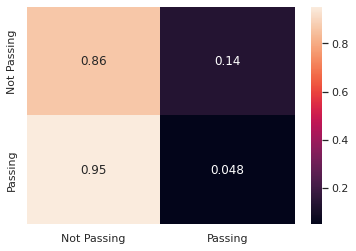

In [ ]:
# Make predicitons and evaluate your model
print('Training Scores')

# Define labels for the confusion matrix
labels = ['Not Passing', 'Passing']

# Get training predictions and round them to integers instead of floats
train_preds = np.rint(class_model.predict(X_train_proc))

# Classification Report
print(classification_report(y_train, train_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_train, train_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.show()
print('\n')
print('Testing Scores')

# Get testing predictions and round them to integers
test_preds = np.rint(class_model.predict(X_test_proc))

# Classification report
print(classification_report(y_test, test_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, test_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.show();

### Evaluation

It's clear to see that the model is overfitting, which is causing our testing data to stop improving. 

I'm going run the model again only this time I'm going to decrease the amount of epochs used to 7, since that's where the biggest split can be seen.  

## Model 2

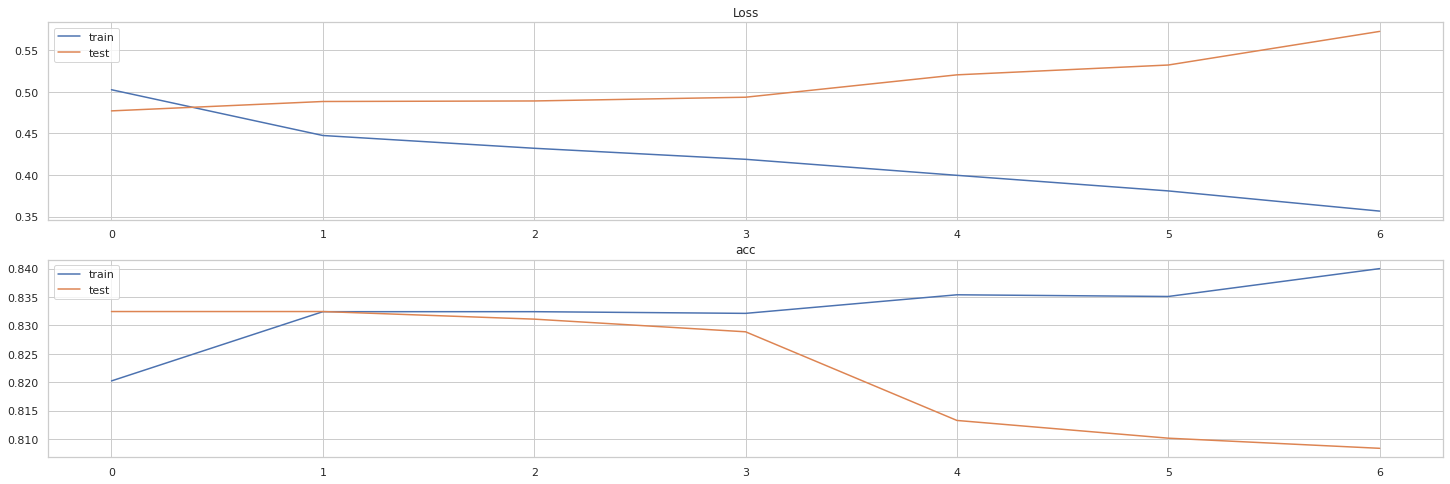

In [ ]:
class_model_2 = Sequential()

# Input layer. I'm using the number of features after PCA has been applied as a rule of thumb.
class_model_2.add(Dense(300, activation = 'relu', input_dim = X_train_proc.shape[1]))

# Create hidden layers
class_model_2.add(Dense(50, activation = 'relu'))


# Since this is a binary classification, the activation function of our final layer needs to be 'sigmoid'
class_model_2.add(Dense(1, activation = 'sigmoid'))

# compile model with metrics
class_model_2.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# 
history_2 = class_model_2.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 7, verbose=0)

# plot learning history
plot_history(history_2, 'acc')

### Model 2 - Score (81%)

Training Scores
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      5611
           1       0.82      0.18      0.30      1120

    accuracy                           0.86      6731
   macro avg       0.84      0.59      0.61      6731
weighted avg       0.85      0.86      0.82      6731



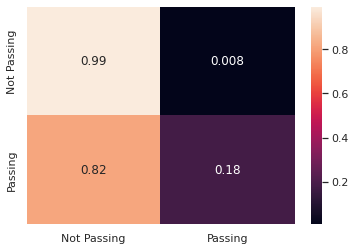



Testing Scores
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1870
           1       0.05      0.01      0.01       374

    accuracy                           0.81      2244
   macro avg       0.44      0.49      0.45      2244
weighted avg       0.70      0.81      0.75      2244



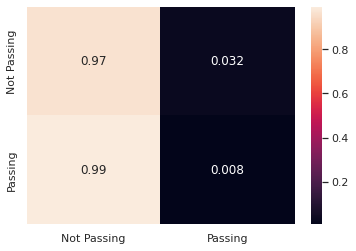

In [ ]:
# Make predicitons and evaluate your model
print('Training Scores')

# Define labels for the confusion matrix
labels = ['Not Passing', 'Passing']

# Get training predictions and round them to integers instead of floats
train_preds = np.rint(class_model_2.predict(X_train_proc))

# Classification Report
print(classification_report(y_train, train_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_train, train_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.show()
print('\n')
print('Testing Scores')

# Get testing predictions and round them to integers
test_preds = np.rint(class_model_2.predict(X_test_proc))

# Classification report
print(classification_report(y_test, test_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, test_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.show();

### Evaluation

There's still some over fitting to model, but our test score is now at 82%, which is great coming from 73%. We can still see that there is a dropoff at 6 epochs.

I'm going to impliment the Dropout Regularization to see if we can increase our testing score. I'm also going to slightly adjust the neurons.

# Dropout 

## Model 1 - Dropout

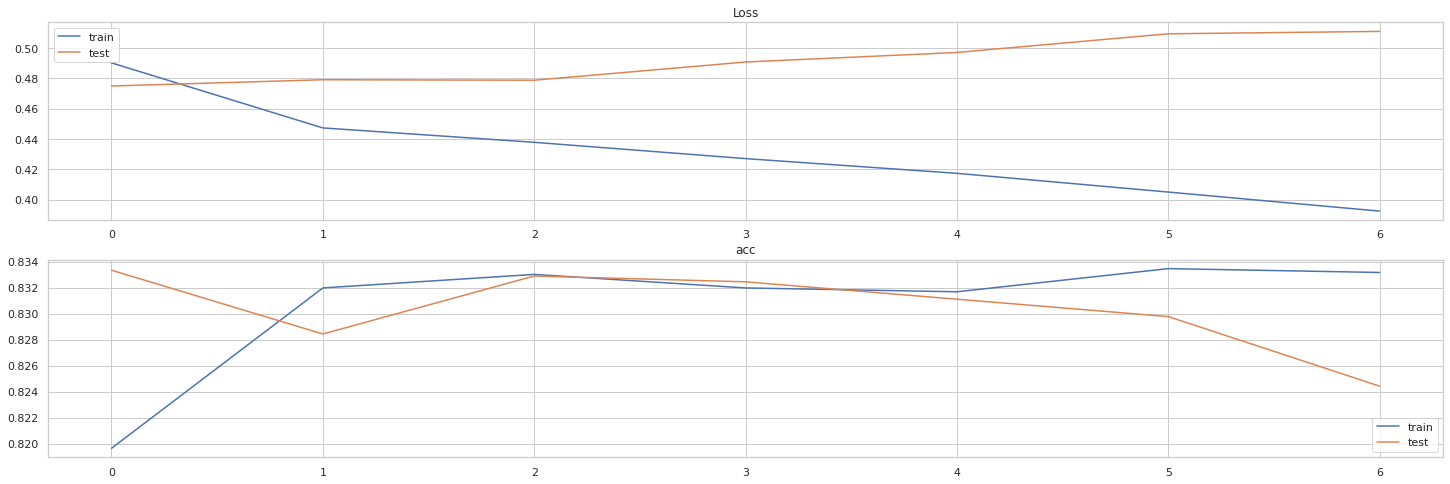

In [ ]:
# Instentiate the model
drop_model = Sequential()

# Input layer
drop_model.add(Dense(200, activation = 'relu', input_dim = X_train_proc.shape[1]))
drop_model.add(Dropout(.2))

# Hidden layers
drop_model.add(Dense(40, activation = 'relu'))
 
# Output Layer
drop_model.add(Dense(1, activation = 'sigmoid'))

# Compile
drop_model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# History
drop_history = drop_model.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 7, verbose=0)

# plot learning history
plot_history(drop_history, 'acc')

### Dropout 1 - Score (82%)

Training Scores
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      5611
           1       0.80      0.10      0.18      1120

    accuracy                           0.85      6731
   macro avg       0.82      0.55      0.55      6731
weighted avg       0.84      0.85      0.79      6731



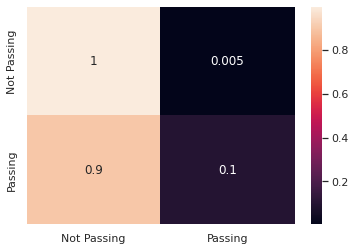



Testing Scores
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1870
           1       0.17      0.01      0.02       374

    accuracy                           0.82      2244
   macro avg       0.50      0.50      0.46      2244
weighted avg       0.72      0.82      0.76      2244



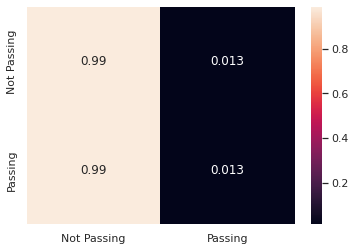

In [ ]:
# Make predicitons and evaluate your model
print('Training Scores')

# Define labels for the confusion matrix
labels = ['Not Passing', 'Passing']

# Get training predictions and round them to integers instead of floats
train_preds = np.rint(drop_model.predict(X_train_proc))

# Classification Report
print(classification_report(y_train, train_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_train, train_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.show()
print('\n')
print('Testing Scores')

# Get testing predictions and round them to integers
test_preds = np.rint(drop_model.predict(X_test_proc))

# Classification report
print(classification_report(y_test, test_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, test_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.show();

### Evaluation

Awesome, our score increased to 82% when we implimented the a dropout of 45%. 

## Model 2: Dropout 2 - ropout's Revenge

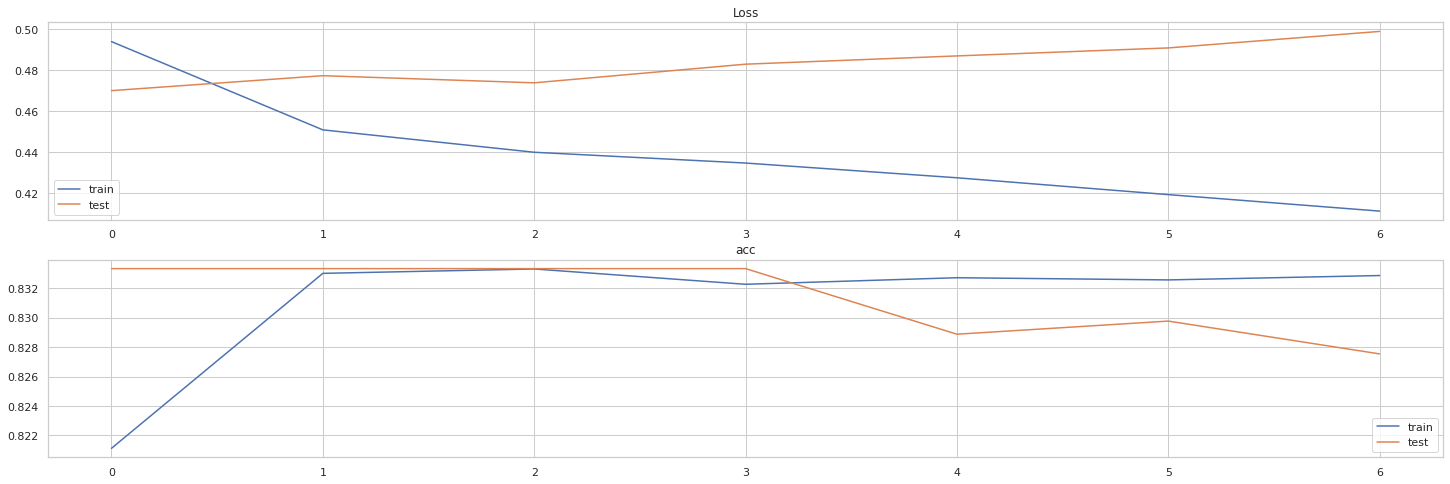

In [ ]:
# Instentiate the model
drop_model_2 = Sequential()

# Input layer
drop_model_2.add(Dense(200, activation = 'relu', input_dim = X_train_proc.shape[1]))
drop_model_2.add(Dropout(.3))

# Hidden layers
drop_model_2.add(Dense(40, activation = 'relu'))

# Output Layer
drop_model_2.add(Dense(1, activation = 'sigmoid'))

# Compile
drop_model_2.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# History
drop_history_2 = drop_model_2.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 7, verbose=0)

# plot learning history
plot_history(drop_history_2, 'acc')

### Dropout's Revenge - Score (83%)


Training Scores
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      5611
           1       0.79      0.03      0.05      1120

    accuracy                           0.84      6731
   macro avg       0.81      0.51      0.48      6731
weighted avg       0.83      0.84      0.77      6731



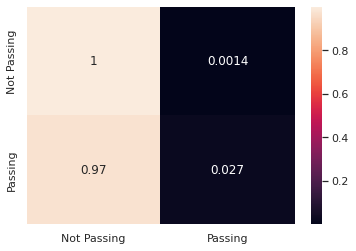



Testing Scores
              precision    recall  f1-score   support

           0       0.83      0.99      0.91      1870
           1       0.07      0.00      0.01       374

    accuracy                           0.83      2244
   macro avg       0.45      0.50      0.46      2244
weighted avg       0.70      0.83      0.76      2244



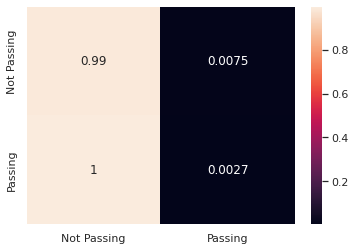

In [ ]:
# Make predicitons and evaluate your model
print('Training Scores')

# Define labels for the confusion matrix
labels = ['Not Passing', 'Passing']

# Get training predictions and round them to integers instead of floats
train_preds = np.rint(drop_model_2.predict(X_train_proc))

# Classification Report
print(classification_report(y_train, train_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_train, train_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.show()
print('\n')
print('Testing Scores')

# Get testing predictions and round them to integers
test_preds = np.rint(drop_model_2.predict(X_test_proc))

# Classification report
print(classification_report(y_test, test_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, test_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.show();

### Evaluation

Awesome, with the smallest adjustment to the amount that is being dropped with 20% to 30% our score went up by one point. 

# Final Evaluation 

With the continious tuning to each new model and even implimenting dropout, I'm confident that we need the dropout regularization to continue to increase the models test score, which is why my final model choice is my second dropout model. 

This model can certainly continue to be adjusted and tunned to better assist with predicting the risk of providing a new loan to certain customers. 